# Metadata Microterroir 

In [100]:
wd = '/home/lfloerl/microterroir/Microbiome/Metadata'
%cd $wd 

/home/lfloerl/microterroir/Microbiome/Metadata


In [101]:
import pandas as pd
import biom
import re
import numpy as np
from qiime2 import Metadata
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import defaultdict

%matplotlib inline

## Import raw metadata files

In [102]:
# FGCZ metadata 
md_pooling = pd.read_csv('RawMD-Demux.csv')
md_pooling['Library_ID'] = md_pooling['Name'].str.split('-').str[-2] + '-' + md_pooling['Name'].str.split('-').str[-1]

# our own sample file 
md_samples = pd.read_csv('RawMD-LibraryPrep-LP3.csv')
md_samples['Library_ID_16S'] = md_samples['unique_16S_ID'].str.split('-').str[-2] + '-' + md_samples['unique_16S_ID'].str.split('-').str[-1]
md_samples['Library_ID_ITS'] = md_samples['unique_ITS_ID'].str.split('-').str[-2] + '-' + md_samples['unique_ITS_ID'].str.split('-').str[-1]

# Make basic 16S / ITS metadata files 

In [103]:
# 16S 
md_16S = pd.merge(md_pooling, md_samples, left_on='Library_ID', right_on='Library_ID_16S')
md_16S = md_16S[['Name', 'SAMPLE_NAME', 'CTRL', 'Project', 'DNA_extraction_plate', 'Plate', 'Bacterial conc. (ng/uL)']]
md_16S['Bacterial conc. (ng/uL)'] = md_16S['Bacterial conc. (ng/uL)'].apply(lambda x: 0.001 if x <= 0 else x)
md_16S.set_index('Name', inplace=True)
md_16S.index.name = 'id'
md_16S.to_csv('16S_md.tsv', sep='\t')

# ITS 
md_ITS = pd.merge(md_pooling, md_samples, left_on='Library_ID', right_on='Library_ID_ITS')
md_ITS = md_ITS[['Name', 'SAMPLE_NAME', 'CTRL', 'Project', 'DNA_extraction_plate', 'Plate', 'Fungal conc. (ng/uL)']]
md_ITS['Fungal conc. (ng/uL)'] = md_ITS['Fungal conc. (ng/uL)'].apply(lambda x: 0.001 if x <= 0 else x)
md_ITS.set_index('Name', inplace=True)
md_ITS.index.name = 'id'
md_ITS.to_csv('ITS_md.tsv', sep='\t')

In [104]:
md_ITS.head()

,SAMPLE_NAME,CTRL,Project,DNA_extraction_plate,Plate,Fungal conc. (ng/uL)
id,,,,,,
364526_478-LP3-ITS-1054,DNA24_negCtrl_2,NegCtrl,BotrytizedWine,DNA41,P11,3.0
364526_357-LP3-ITS-0933,MV_Post-AF_Plot4_2023-10-11,Sample,Lavaux,DNA42,P10,0.7
364526_236-LP3-ITS-0812,Lavaux_2023-09-20_must_Plot14_RepE,Sample,Lavaux,DNA40,P9,3.5
364526_479-LP3-ITS-1055,DNA41_negCtrl_2,NegCtrl,BotrytizedWine,DNA41,P11,15.3
364526_358-LP3-ITS-0934,MV_Must_Plot9_2023-09-23,Sample,Lavaux,DNA42,P10,7.8


# Make Lavaux Metadata files 

In [105]:
# Lavaux metadata 
md_lavaux = pd.read_csv('RawMD-LavauxSamples.csv')
md_lavaux = md_lavaux.dropna(how='all')

# split 
md_lavaux[['Time_point', 'Year']] = md_lavaux['Collection_ID'].str.split('_', expand=True)
# drop unnecessary columns 
md_lavaux = md_lavaux.drop(columns=["DNAextraction_plate", 'Row #', "Lat.",  "Long.", 'Plot #', 'Collected by ', 'Vine #', 'id_sampling', "DNAextraction_well", "openBIS identifier", "Comment"])
# set col types 
md_lavaux['LOCATION_ID'] = md_lavaux['LOCATION_ID'].astype('category')
md_lavaux['Time_point'] = md_lavaux['Time_point'].astype('category')
md_lavaux['Year_Cat'] = 'Year' + md_lavaux['Year']
md_lavaux['Year'] = md_lavaux['Year'].astype('int64')  
# rename the columns for the dense sampling in 2021 
md_lavaux = md_lavaux.rename(columns={"LOCATION_ID": "Plot_ID", "sample type":"sample_type"})

## Add geospatial clusters

In [106]:
# plots metadata
md_plot_raw = pd.read_csv('RawMD-Lavaux_plots.csv')

### Quadrant 

In [107]:
# Extract the longitude, latitude, and sample ID columns
longitude = md_plot_raw['Longitude'].values
latitude = md_plot_raw['Latitude'].values
sample_ids = md_plot_raw.index

# Define the bounds for the Quadtree
x_bounds = (longitude.min(), longitude.max())
y_bounds = (latitude.min(), latitude.max())

# Initialize the Quadtree structure
threshold = 4  # Set the threshold for splitting, change this as per your clustering scheme
quadtree = defaultdict(list)

# Function to determine the quadrant based on the coordinate
def get_quadrant(x, y):
    x_mid = (x_bounds[0] + x_bounds[1]) / 2
    y_mid = (y_bounds[0] + y_bounds[1]) / 2
    
    if x < x_mid:
        if y < y_mid:
            return "SW"  # South-West
        else:
            return "NW"  # North-West
    else:
        if y < y_mid:
            return "SE"  # South-East
        else:
            return "NE"  # North-East

# Insert each sample into the quadtree based on its coordinates
for sample_id, x, y in zip(sample_ids, longitude, latitude):
    quadrant = get_quadrant(x, y)
    quadtree[quadrant].append((sample_id, x, y))

# Collect the clustered points into a DataFrame
clustered_samples = []
for quadrant, points in quadtree.items():
    for sample_id, x, y in points:
        clustered_samples.append([sample_id, x, y, quadrant])

# Convert the clustered points into a DataFrame using pd.concat
cluster_df = pd.DataFrame(clustered_samples, columns=['SampleID', 'Longitude', 'Latitude', 'Quadrant'])

# Add the 'Quadrant' column to the original md_plots DataFrame
md_plot_raw['Quadrant'] = md_plot_raw.index.map(lambda x: next(quadrant for quadrant, points in quadtree.items() if any(s[0] == x for s in points)))

### K-Means

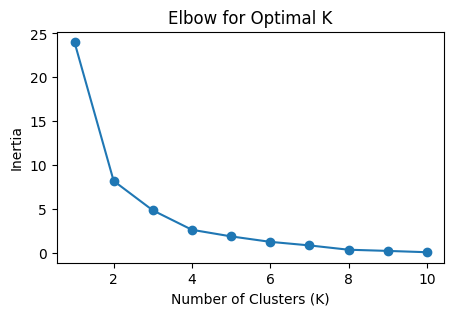

In [108]:
# Assuming md_plots contains 'latitude' and 'longitude' columns
latitude = md_plot_raw['Latitude'].values
longitude = md_plot_raw['Longitude'].values
sample_ids = md_plot_raw.index

# Step 1: Create a DataFrame with coordinates
coords = np.vstack([latitude, longitude]).T

# Step 2: Scale the data (optional, but sometimes helpful for numerical stability)
scaler = StandardScaler()
scaled_coords = scaler.fit_transform(coords)

# Step 3: Use the Elbow Method to determine the optimal number of clusters (K)
# Elbow Method: Find the point where the inertia (within-cluster sum of squared distances) stops decreasing significantly
inertia = []
K_range = range(1, 11)  # Test K from 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_coords)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(5, 3))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

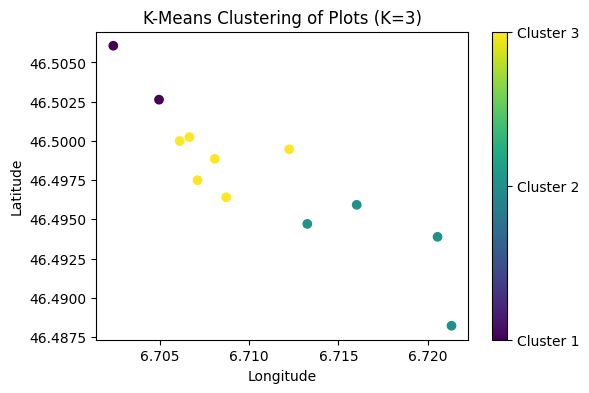

In [109]:
# Step 4: Apply K-Means clustering (let's assume K=3 based on the elbow method)
optimal_k = 3  # You can set this based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
md_plot_raw['Cluster'] = kmeans.fit_predict(scaled_coords)
# Convert the cluster labels into the 'Cluster1', 'Cluster2', ... format
md_plot_raw['Cluster'] = md_plot_raw['Cluster'].apply(lambda x: f'Cluster{x + 1}')

# Step 5: Visualize the clusters on a scatter plot with discrete colors for clusters
plt.figure(figsize=(6, 4))
scatter = plt.scatter(md_plot_raw['Longitude'], md_plot_raw['Latitude'], c=md_plot_raw['Cluster'].astype('category').cat.codes, cmap='viridis', marker='o')

# Adding a colorbar with discrete ticks
cbar = plt.colorbar(scatter, label='')
cbar.set_ticks(np.arange(optimal_k))  # Set the ticks to match the number of clusters
cbar.set_ticklabels([f'Cluster {i + 1}' for i in range(optimal_k)]) 
plt.title(f'K-Means Clustering of Plots (K={optimal_k})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Plot Properties PCA K-Means Cluster
> note, this csv is generated in the Plots_PCA notebook 

In [110]:
md_plot_clusters = pd.read_csv('Plot_Clusters.csv')
md_plots = pd.merge(md_plot_raw, md_plot_clusters, on='Plot', how='inner')

### Merge w Metadata

In [111]:
# 16S 
md_16S = md_16S.reset_index(names='id')
# merge with Lavaux metadata
merged_16S = pd.merge(md_16S[['id', 'SAMPLE_NAME', 'Bacterial conc. (ng/uL)']], 
    md_lavaux, on='SAMPLE_NAME', how='right')
# merge plot metadata 
merged_16S['Plot'] = merged_16S['Plot_ID'].str.extract(r'(\d+)$').astype(int)
merged_16S = pd.merge(merged_16S, md_plots, left_on='Plot', right_on='Plot', how='left')
# add washed column 
merged_16S['washed'] = merged_16S['SAMPLE_NAME'].apply(lambda x: 'washed' if 'washed' in str(x).lower() else 'no')
# set inex again 
merged_16S = merged_16S.set_index('id')
merged_16S = merged_16S[~merged_16S.index.isnull()]
# drop duplicate indices 
merged_16S = merged_16S.loc[~merged_16S.index.duplicated(keep='first')]
merged_16S.to_csv('16S_lavaux.tsv', sep='\t')

# ITS 
md_ITS = md_ITS.reset_index(names='id')
merged_ITS = pd.merge(md_ITS[['id', 'SAMPLE_NAME', 'Fungal conc. (ng/uL)']], 
    md_lavaux, on='SAMPLE_NAME', how='right')
merged_ITS['Plot'] = merged_ITS['Plot_ID'].str.extract(r'(\d+)$').astype(int)
merged_ITS = pd.merge(merged_ITS, md_plots, left_on='Plot', right_on='Plot', how='left')
merged_ITS['washed'] = merged_ITS['SAMPLE_NAME'].apply(lambda x: 'washed' if 'washed' in str(x).lower() else 'no')
merged_ITS = merged_ITS.set_index('id')
merged_ITS = merged_ITS[~merged_ITS.index.isnull()]
merged_ITS = merged_ITS.loc[~merged_ITS.index.duplicated(keep='first')]
merged_ITS.to_csv('ITS_lavaux.tsv', sep='\t')

In [112]:
# check if it imports
md = Metadata.load('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv')

### Lavaux dense berry sampling harvest 2021 
add new coordinates

In [113]:
# Lavaux metadata 
md_lavaux = pd.read_csv('RawMD-LavauxSamples.csv')
md_lavaux = md_lavaux.dropna(how='all')

# new coordinates file 
md_coordinates = pd.read_csv('RawMD-Lavaux-DenseSampling2021-coordinates.tsv', sep='\t')


# 16S 
merged_16S_21 = pd.merge(md_16S[['id', 'SAMPLE_NAME']], 
    md_lavaux, on='SAMPLE_NAME', how='right')
# subset to samples from harvest 2021 
harvest21_16S = merged_16S_21[merged_16S_21['Collection_ID'] == 'Harvest_2021']
# merge! 
merged_harvest21_16S = harvest21_16S.merge(
    md_coordinates,
    left_on=['Plot #', 'Row #', 'Vine #'],
    right_on=['plot', 'row', 'vine'],
    how='left')
# drop some columns 
merged_harvest21_16S = merged_harvest21_16S.drop(columns=['Collection_ID', 'sample type', 'DNAextraction_plate',
       'DNAextraction_well', 'LOCATION_ID', 'openBIS identifier',
       'Collected by ', 'COLLECTION_DATE', 'Comment', 'id_sampling', 'Plot #',
       'Row #', 'Vine #', 'Lat.', 'Long.', 'Replicate', 'id '])
# set index and save 
merged_harvest21_16S = merged_harvest21_16S.set_index('id')
merged_harvest21_16S = merged_harvest21_16S[~merged_harvest21_16S.index.isnull()]
merged_harvest21_16S = merged_harvest21_16S.loc[~merged_harvest21_16S.index.duplicated(keep='first')]
merged_harvest21_16S.to_csv('16S_lavaux_Harvest21.tsv', sep='\t')


# same for ITS
merged_ITS_21 = pd.merge(md_ITS[['id', 'SAMPLE_NAME']], md_lavaux, on='SAMPLE_NAME', how='right')
harvest21_ITS = merged_ITS_21[merged_ITS_21['Collection_ID'] == 'Harvest_2021']
merged_harvest21_ITS = harvest21_ITS.merge( md_coordinates,left_on=['Plot #', 'Row #', 'Vine #'],
                                           right_on=['plot', 'row', 'vine'], how='left')
merged_harvest21_ITS = merged_harvest21_ITS.drop(columns=['Collection_ID', 'sample type', 'DNAextraction_plate',
       'DNAextraction_well', 'LOCATION_ID', 'openBIS identifier',
       'Collected by ', 'COLLECTION_DATE', 'Comment', 'id_sampling', 'Plot #',
       'Row #', 'Vine #', 'Lat.', 'Long.', 'Replicate', 'id '])
merged_harvest21_ITS = merged_harvest21_ITS.set_index('id')
merged_harvest21_ITS = merged_harvest21_ITS[~merged_harvest21_ITS.index.isnull()]
merged_harvest21_ITS = merged_harvest21_ITS.loc[~merged_harvest21_ITS.index.duplicated(keep='first')]
merged_harvest21_ITS.to_csv('ITS_lavaux_Harvest21.tsv', sep='\t')

merged_harvest21_16S.head()

,SAMPLE_NAME,plot,row,vine,Lat,Long
id,,,,,,
364527_027-LP3-16S-0027,Lavaux_2021-09-30_must_Plot4_Row6/Vine10_ID1,4,6,10,46.498412,6.708026
364527_048-LP3-16S-0048,Lavaux_2021-09-30_must_Plot4_Row6/Vine30_ID2,4,6,30,46.498521,6.708104
364527_166-LP3-16S-0166,Lavaux_2021-09-30_must_Plot4_Row7/Vine20_ID3,4,7,20,46.498458,6.708079
364527_019-LP3-16S-0019,Lavaux_2021-09-30_must_Plot4_Row8/Vine10_ID4,4,8,10,46.498383,6.708045
364527_075-LP3-16S-0075,Lavaux_2021-09-30_must_Plot4_Row8/Vine30_ID5,4,8,30,46.498503,6.708129


# Valais metadata

In [114]:
# raw valais data on plots etc
md_valais = pd.read_csv('RawMD-Valais.csv')

# raw valais agronomical data
md_valais_ag = pd.read_csv('RawMD-Valais-agronomical_data.csv')
md_valais_ag = md_valais_ag.drop(columns=['Variety'])

merged_valais = pd.merge(md_valais_ag, md_valais, on='Plot', how='outer')

# convert the longitude and latitude
merged_valais['Latitude'] = merged_valais['N_deg'] + merged_valais['N_min'] / 60 + md_valais['N_sec'] / 3600
merged_valais['Longitude'] = merged_valais['E_deg'] + merged_valais['E_min'] / 60 + md_valais['E_sec'] / 3600
# drop some cols 
merged_valais = merged_valais.drop(columns=['N_deg', 'N_min', 'N_sec', 'E_deg', 'E_min', 'E_sec','GEOL_Desc'])
merged_valais['Year'] = '2023'
merged_valais['Variety'] = merged_valais['Variety'].str.replace('Pinot Noir', 'PinotNoir')

merged_valais['CC_Cat'] = 'CC_' + merged_valais['Cover_Cropping'].astype(str)

# make water stress categories
def categorize_water_stress(value):
    if value >= 7000:
        return 'Low Water Stress'
    elif 4000 <= value < 7000:
        return 'Moderate Water Stress'
    elif value < 4000:
        return 'High Water Stress'
    else:
        return 'Unknown'  # For any unexpected values

merged_valais['Water_Stress_Cat'] = merged_valais['Water_Stress'].apply(categorize_water_stress)

In [115]:
# VALAIS metadata: merge with seq id 
# Filter md_16S for 'Project' = 'Valais'
md_16S_valais = md_16S[md_16S['Project'] == 'Valais']
# Extract numeric part from 'SAMPLE_NAME' and create a new column for merging
# Extract numeric part from 'SAMPLE_NAME'
md_16S_valais['Num'] = md_16S_valais['SAMPLE_NAME'].str.extract(r'_(\d+)$')
# Drop rows where 'Num' is NaN
md_16S_valais = md_16S_valais.dropna(subset=['Num'])
# Convert 'Num' to integers
md_16S_valais['Num'] = md_16S_valais['Num'].astype(int)
merged_16S_valais = md_16S_valais.merge(merged_valais, on='Num', how='inner')
merged_16S_valais = merged_16S_valais.drop(columns=['CTRL', 'Porte_geffe', 'DNA_extraction_plate', 'Plate','Project', 'Bacterial conc. (ng/uL)','Num'])


# NOW: merge with Lavaux must 2023 samples 
merged_16S_must23 = merged_16S[(merged_16S['Collection_ID'] == 'Harvest_2023') & 
                               (merged_16S['sample_type'] == 'must')]
merged_16S_must23 = merged_16S_must23.reset_index(names='id')
merged_16S_must23 = merged_16S_must23.drop(columns=['Bacterial conc. (ng/uL)', 'sample_type', 'Altitude', 'Average_slope', 'Exposition',
       'Min_radiation', 'Time_point', 'Max_radiation', 'Collection_ID', 'COLLECTION_DATE','Replicate', 'Average_radiation', 'Soil_thickness','Plot_ID', 'Coordinates', 'washed', 'Hydromorphie', 'Hydromorphie_code', 'Geology'])
merged_16S_must23['Variety'] ='Chasselas'
# Concatenate the two dataframes, aligning on column names
merged_16S_valais = pd.concat([merged_16S_valais, merged_16S_must23], join='outer', ignore_index=True)

merged_16S_valais = merged_16S_valais.set_index('id')
merged_16S_valais.to_csv('16S_Valais_and_Lavaux23.tsv', sep='\t')

/scratch/lfloerl/tmpdata/ipykernel_1707916/1052241.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  md_16S_valais['Num'] = md_16S_valais['SAMPLE_NAME'].str.extract(r'_(\d+)$')


In [116]:
# VALAIS metadata: merge with seq id 
# Filter md_ITS for 'Project' = 'Valais'
md_ITS_valais = md_ITS[md_ITS['Project'] == 'Valais']
md_ITS_valais['Num'] = md_ITS_valais['SAMPLE_NAME'].str.extract(r'_(\d+)$')
md_ITS_valais = md_ITS_valais.dropna(subset=['Num'])
md_ITS_valais['Num'] = md_ITS_valais['Num'].astype(int)
merged_ITS_valais = md_ITS_valais.merge(merged_valais, on='Num', how='inner')
merged_ITS_valais = merged_ITS_valais.drop(columns=[
    'CTRL', 'Porte_geffe', 'DNA_extraction_plate', 'Plate', 'Project', 
    'Fungal conc. (ng/uL)', 'Num'])

# NOW: merge with Lavaux must 2023 samples 
merged_ITS_must23 = merged_ITS[
    (merged_ITS['Collection_ID'] == 'Harvest_2023') & 
    (merged_ITS['sample_type'] == 'must')]

merged_ITS_must23 = merged_ITS_must23.reset_index(names='id')
merged_ITS_must23.rename(columns={'Plot_ID': 'Location'}, inplace=True)
merged_ITS_must23 = merged_ITS_must23.drop(columns=[
    'Fungal conc. (ng/uL)', 'sample_type', 'Altitude', 'Average_slope', 
    'Exposition', 'Min_radiation', 'Time_point', 'Max_radiation', 
    'Collection_ID', 'COLLECTION_DATE', 'Replicate', 'Average_radiation', 
    'Soil_thickness', 'Coordinates', 'washed', 'Hydromorphie', 
    'Hydromorphie_code', 'Geology'])

merged_ITS_must23['Variety'] = 'Chasselas'
merged_ITS_must23['Region'] = 'Lavaux'
merged_ITS_valais['Region'] = 'Valais'

merged_ITS_valais = pd.concat([merged_ITS_valais, merged_ITS_must23], join='outer', ignore_index=True)

merged_ITS_valais = merged_ITS_valais.set_index('id')
merged_ITS_valais.to_csv('ITS_Valais_and_Lavaux23.tsv', sep='\t')

/scratch/lfloerl/tmpdata/ipykernel_1707916/1900799564.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  md_ITS_valais['Num'] = md_ITS_valais['SAMPLE_NAME'].str.extract(r'_(\d+)$')


# Berry Chemistry Metadata

do not compare across Lavaux and Valais because different methods to measure! 

## Lavaux

In [117]:
# ITS lavaux berry samples 
ITS_lavaux = pd.read_csv('ITS_lavaux.tsv', sep='\t')
berries_lavaux = ITS_lavaux[ITS_lavaux['sample_type'] == 'must']
# add a column for plot & replicates - note in 2022 we collected replicate samples but measured pooled samples  
berries_lavaux['Plot_Rep'] = berries_lavaux.apply(
    lambda row: str(row['Plot']) if row['Year'] == 2022 else str(row['Plot']) + (str(row['Replicate']) if pd.notna(row['Replicate']) else ''),
    axis=1)
# drop some 
berries_lavaux = berries_lavaux.drop(columns=['Altitude', 'Average_slope', 'Exposition',
       'Min_radiation', 'Max_radiation', 'Average_radiation', 'Soil_thickness','sample_type',
       'Soil_type', 'Soil_depth', 'Hydromorphie', 'Hydromorphie_code','Fungal conc. (ng/uL)',
       'Geology', 'Coordinates', 'Latitude', 'Longitude', 'washed', 'Replicate', 'Plot'])

# berry chemistry data 
md_BC_lavaux = pd.read_csv('RawMD-Lavaux_berry_chemistry.csv')
md_BC_lavaux = md_BC_lavaux.drop(columns=['Comments', 'Month', 'Day', 'ID'])
md_BC_lavaux.rename(columns={'Pheno_Stage': 'Time_point'}, inplace=True)

# merge!
merged_BC_ITS = pd.merge(berries_lavaux, md_BC_lavaux, on=['Plot_Rep', 'Year', 'Time_point'], how='left')

merged_BC_ITS = merged_BC_ITS.set_index('id')
merged_BC_ITS.to_csv('ITS_Lavaux_BerryChemistry.tsv', sep='\t')

/scratch/lfloerl/tmpdata/ipykernel_1707916/3667198990.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  berries_lavaux['Plot_Rep'] = berries_lavaux.apply(


# Soil properties 

In [118]:
# Soil pH 
md_soil_pH = pd.read_csv('RawMD-Soil-pH.csv')
md_soil_pH = md_soil_pH.dropna(axis=0, how='all').dropna(axis=1, how='all')

# Soil Properties
md_soil_properties = pd.read_csv('RawMD-Soil_properties.csv')
md_soil_properties = md_soil_properties.dropna(axis=1, how='all')
md_soil_properties['Plot_ID'] = 'Lavaux_' + md_soil_properties['Plot']

In [119]:
# Lavaux ITS soil metadata 
soil_lavaux = ITS_lavaux[ITS_lavaux['sample_type'] == 'soil']
soil_lavaux = soil_lavaux.drop(columns=['Coordinates', 'Latitude', 'Longitude', 'washed', 
                                        'Fungal conc. (ng/uL)', 'Collection_ID',
                                       'Replicate', 'Time_point'])

# merge with soil properties from SoilConseil 
merged_ITS_soil = pd.merge(soil_lavaux, md_soil_properties, on=['Plot_ID'], how='left')
# merge with soil pH 
merged_ITS_soil_all = pd.merge(merged_ITS_soil, md_soil_pH, on=['SAMPLE_NAME'], how='left')


merged_ITS_soil_all = merged_ITS_soil_all.set_index('id')
merged_ITS_soil_all.to_csv('ITS_Lavaux_Soil.tsv', sep='\t')

In [120]:
# Lavaux 16S soil metadata 
merged_16S = merged_16S.reset_index(names='id')
soil_lavaux = merged_16S[merged_16S['sample_type'] == 'soil']
soil_lavaux = soil_lavaux.drop(columns=['Coordinates', 'Latitude', 'Longitude', 'washed', 
                                        'Bacterial conc. (ng/uL)', 'Collection_ID',
                                       'Replicate', 'Time_point'])

# merge with soil pH 
merged_16S_soil = pd.merge(soil_lavaux, md_soil_pH, on=['SAMPLE_NAME'], how='left')
# merge with soil properties from SoilConseil 
merged_16S_soil_all = pd.merge(merged_16S_soil, md_soil_properties, on=['Plot_ID'], how='left')

merged_16S_soil_all = merged_16S_soil_all.set_index('id')
merged_16S_soil_all.to_csv('16S_Lavaux_Soil.tsv', sep='\t')

# Vineyard management and Physiology 

In [121]:
md_management = pd.read_csv('Raw-MD_Vineyard_MV_data.csv')

# only keep relevant columns 
md_management = md_management.drop(columns=['Must_Oechsle', 'Wine_Tartatic_Acid',
                                            'Wine_Malic_Acid', 'Wine_Glucose','Wine_Fructose', 
                                            'Wine_Lactic_Acid', 'Wien_Glycerol', 'Wine_Acetic_Acid'])

# Lavaux ITS soil metadata 
ITS_lavaux_small = ITS_lavaux.drop(columns=['Coordinates', 'Latitude', 'Longitude', 'washed', 
                                        'Fungal conc. (ng/uL)', 'Collection_ID',
                                       'Replicate', 'Time_point'])

# merge 
ITS_management = pd.merge(ITS_lavaux_small, md_management, on=['Plot', 'Year'], how='left')

ITS_management = ITS_management.set_index('id')
ITS_management.to_csv('ITS_Lavaux_Management.tsv', sep='\t')

# Microvinification chemistry

In [122]:
md_management = pd.read_csv('Raw-MD_Vineyard_MV_data.csv')

# only keep relevant columns 
md_management = md_management[['Plot', 'Year', 'Must_Oechsle', 'Wine_Tartatic_Acid', 
                                'Wine_Malic_Acid', 'Wine_Glucose', 'Wine_Fructose', 
                                'Wine_Lactic_Acid', 'Wien_Glycerol', 'Wine_Acetic_Acid']]

# Lavaux ITS soil metadata 
ITS_lavaux_mv = ITS_lavaux[ITS_lavaux['sample_type'].isin(['MV-must', 'Post-AF', 'Post-MLF'])]
ITS_lavaux_mv = ITS_lavaux_mv.drop(columns=['Coordinates', 'Latitude', 'Longitude', 'washed', 
                                        'Fungal conc. (ng/uL)', 'Collection_ID',
                                       'Replicate', 'Time_point'])

# merge 
ITS_mv = pd.merge(ITS_lavaux_small, md_management, on=['Plot', 'Year'], how='left')

ITS_mv = ITS_mv.set_index('id')
ITS_mv.to_csv('ITS_Lavaux_MV_Chemistry.tsv', sep='\t')

# Climate

In [123]:
md_climate = pd.read_csv('RawMD-Lavaux-Climate.csv')
md_climate['Plot'] = md_climate['Plot'].str.replace('Plot_', '').astype(int)

# ITS 
ITS_lavaux_climate = ITS_lavaux.copy()
ITS_lavaux_climate = ITS_lavaux_climate.drop(columns=['Coordinates', 'Latitude', 'Longitude', 'washed', 
                                        'Fungal conc. (ng/uL)', 'Collection_ID',
                                       'Replicate', 'Time_point'])
# merge 
ITS_lavaux_climate_2 = pd.merge(ITS_lavaux_climate, md_climate, on=['Plot', 'Year'], how='left')
ITS_lavaux_climate_2 = ITS_lavaux_climate_2.set_index('id')
ITS_lavaux_climate_2.to_csv('ITS_Lavaux_Climate.tsv', sep='\t')
                                             
# 16S
bac_lavaux_climate = merged_16S.copy()
bac_lavaux_climate = bac_lavaux_climate.drop(columns=['Coordinates', 'Latitude', 'Longitude', 'washed', 
                                        'Bacterial conc. (ng/uL)', 'Collection_ID',
                                       'Replicate', 'Time_point'])
# merge 
bac_lavaux_climate_2 = pd.merge(bac_lavaux_climate, md_climate, on=['Plot', 'Year'], how='left')
bac_lavaux_climate_2 = bac_lavaux_climate_2.set_index('id')
bac_lavaux_climate_2.to_csv('16S_Lavaux_Climate.tsv', sep='\t')